### Before running, make sure that Graphviz is installed on your PC and is added to system path
### https://graphviz.gitlab.io/download/

In [42]:
# IMPORTS
import os
import ipywidgets as widgets
import graphviz
import sqlite3

from subprocess import Popen, PIPE as P



In [44]:
# Path to SQLITE db generated by noWorkFlow
NOW2_SQLITE_PATH = 'C:/Users/linha/Desktop/ws/py-scripts-examples/age-avg/.noworkflow/db.sqlite'

In [45]:
class DotDisplay:

    def __init__(self, dot):
        self.dot = dot
    
    def _ipython_display_(self):
        from IPython.display import display
        bundle = {}

        dot = self.dot
        bundle['text/vnd.graphviz'] = dot

        try:
            kwargs = {} if os.name != 'nt' else {"creationflags": 0x08000000}
            p = Popen(['dot', '-T', "svg"], stdout=P, stdin=P, stderr=P, **kwargs)
            image = p.communicate(dot.encode('utf-8'))[0]
            bundle['image/svg+xml'] = image.decode("utf-8")
        except OSError as e:
            if e.errno != os.errno.ENOENT:
                raise

        #bundle['text/plain'] = '\n'.join(map(str, self.log))
        display(bundle, raw=True)

In [49]:
from pyalgdb.node import Node
from pyalgdb.validity import Validity
from pyalgdb.provenance_navigation import ProvenanceNavigation
from ipywidgets import VBox, Output

class JNNavigationStrategy(ProvenanceNavigation):
    
    def __init__(self, *args, **kwargs):
        super(JNNavigationStrategy, self).__init__(*args, **kwargs)
        #self.joutput = Output()
        
    #@property
    #def view(self):
    #    return self.joutput
    
    def evaluate(self, node: Node) -> Node:
        self.exec_tree.node_under_evaluation = node
        vis = Visualization(self.exec_tree)
        vis.generate_exec_tree(str(id(node)))
        #self.joutput.clear_output()
        #with self.joutput:
        print(str(vis.graph))
        display(DotDisplay(str(vis.graph)))
        print("-------------------------")
        print("Evaluating node {}".format(node.name))
        print("Name: {}".format(node.name))
        print("Evaluation_id: {}".format(node.id))
        print("Code_component_id: {}".format(node.code_component_id))
        print("Parameters: name | value ")
        for p in node.params:
            print (" {} | {} ".format(p.name, p.value))
        print("Returns: {}".format(node.retrn))
        ans = input("Is correct? Y/N ")
        if ans == "Y" or ans == "y":
            # The YES answer prunes the subtree rooted at N
            self.recursive_validate(node)
        else:
            # The NO answer prunes all the nodes of the ET,
            # exept the subtree rooted at N
            node.validity = Validity.INVALID
            if node.parent is not None:
                for c in node.parent.childrens:
                    if c is not node:
                        self.recursive_validate(c)
            self.exec_tree.node_under_evaluation = None
        return node

In [50]:
from pyalgdb.execution_tree_creator import ExecTreeCreator
from pyalgdb.top_down import TopDown
from pyalgdb.heaviest_first import HeaviestFirst
from pyalgdb.visualization import Visualization
from pyalgdb.provenance_navigation import ProvenanceNavigation
from pyalgdb.single_stepping import SingleStepping
from pyalgdb.divide_and_query import DivideAndQuery

graph 1785078779688 {
	node [shape=box]
	1 [label="calculate.py"]
	1 -- 20 [dir=forward]
	20 [label="main()"]
	{
		graph [rank=same]
		20
	}
	20 -- 21 [dir=forward]
	21 [label="abre_arquivo(FILE_NAME)"]
	20 -- 28 [dir=forward]
	28 [label="leitura_csv(myfile)"]
	20 -- 45 [dir=forward]
	45 [label="processa_dados(data)"]
	20 -- 262 [dir=forward]
	262 [label="calcula_resultado(proc_data)"]
	20 -- 280 [dir=forward]
	280 [label="imprime_resultado(res)"]
	20 -- 296 [dir=forward]
	296 [label="fecha_arquivos(myfile)"]
	{
		graph [rank=same]
		21
		28
		45
		262
		280
		296
	}
	21 -- 24 [dir=forward]
	24 [label="open(name)"]
	{
		graph [rank=same]
		24
	}
	28 -- 34 [dir=forward]
	34 [label="print(\"Processed \"+str(line_count)+\" lines\")"]
	28 -- 36 [dir=forward]
	36 [label="str(line_count)"]
	{
		graph [rank=same]
		34
		36
	}
	45 -- 48 [dir=forward]
	48 [label="enumerate(data)"]
	45 -- 54 [dir=forward]
	54 [label="randint(-100, 100)"]
	45 -- 65 [dir=forward]
	65 [label="randint(-100, 100)"]
	

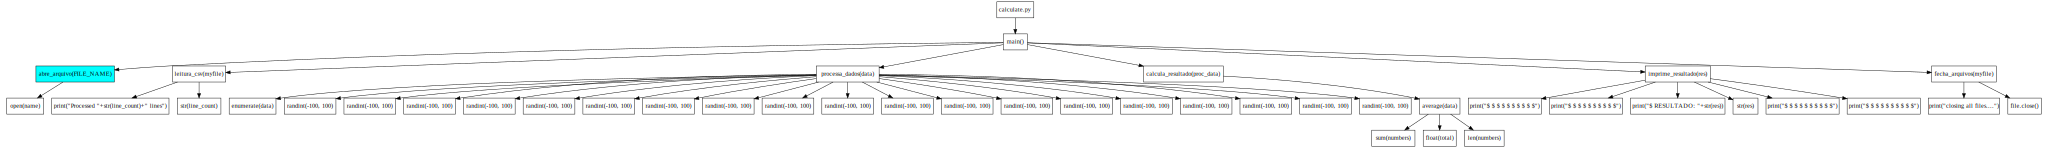

-------------------------
Evaluating node abre_arquivo(FILE_NAME)
Name: abre_arquivo(FILE_NAME)
Evaluation_id: 21
Code_component_id: 228
Parameters: name | value 
 FILE_NAME | 'input.txt' 
Returns: <_io.TextIOWrapper name='input.txt' mode='r' encoding='cp1252'>
Is correct? Y/N N
graph 1785078257312 {
	node [shape=box]
	1 [label="calculate.py"]
	1 -- 20 [dir=forward]
	20 [label="main()"]
	{
		graph [rank=same]
		20
	}
	20 -- 21 [dir=forward]
	21 [label="abre_arquivo(FILE_NAME)" fillcolor=red style=filled]
	20 -- 28 [dir=forward]
	28 [label="leitura_csv(myfile)" fillcolor=green style=filled]
	20 -- 45 [dir=forward]
	45 [label="processa_dados(data)" fillcolor=green style=filled]
	20 -- 262 [dir=forward]
	262 [label="calcula_resultado(proc_data)" fillcolor=green style=filled]
	20 -- 280 [dir=forward]
	280 [label="imprime_resultado(res)" fillcolor=green style=filled]
	20 -- 296 [dir=forward]
	296 [label="fecha_arquivos(myfile)" fillcolor=green style=filled]
	{
		graph [rank=same]
		21
		28


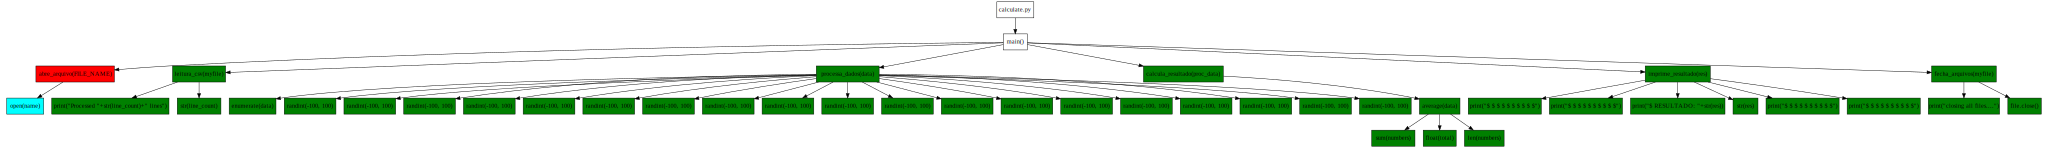

-------------------------
Evaluating node open(name)
Name: open(name)
Evaluation_id: 24
Code_component_id: 193
Parameters: name | value 
 name | 'input.txt' 
Returns: <_io.TextIOWrapper name='input.txt' mode='r' encoding='cp1252'>


In [ ]:

CURSOR = sqlite3.connect(NOW2_SQLITE_PATH).cursor()
creator = ExecTreeCreator(CURSOR)
exec_tree = creator.create_exec_tree()
nav = JNNavigationStrategy(exec_tree, CURSOR)
result_tree = nav.navigate()
vis = Visualization(result_tree)
vis.view_exec_tree_prov('exec_tree',nav.DEPENDENCIES)

In [ ]:
#o = Output()
#with o:
#    print(1234)

In [ ]:
#o

In [ ]:
#o.clear_output()